# Project 3: More Classication

## Part 1: Acquire and Partition Data (5 points)

In [1]:
import numpy as np 
import random
import matplotlib.pyplot as plt
import math

# Set to 1 to standardize, 0 to not standardize
STD = 1

In [2]:
# Getting the Data via Python
data   = np.loadtxt('sonar5841.dat')
# Shuffle the data
np.random.shuffle(data)
data_x = data[:,0:-1]
data_y = data[:,-1]
print('shape of data_x:',data_x.shape)
print('shape of data_y',data_y.shape)

shape of data_x: (208, 60)
shape of data_y (208,)


In [3]:
# X data represent the energy over 60 bands ranging from 0 to 1
# Y data represent the classes, either rock or metal detected
#
# There are 111 metal and 97 rock
# http://archive.ics.uci.edu/ml/datasets/connectionist+bench+(sonar,+mines+vs.+rocks)

# Partitioning the Data
test_data_x = data_x[0:41]
test_data_y = data_y[0:41]

train_data_x = data_x[41:-1]
train_data_y = data_y[41:-1]

# Standardizing
train_x_mean = np.mean(train_data_x)
train_x_std  = np.std(train_data_x)
train_x_mean, train_x_std

if STD:
    train_data_x = (train_data_x - train_x_mean)/train_x_std
    test_data_x = (test_data_x - train_x_mean)/train_x_std

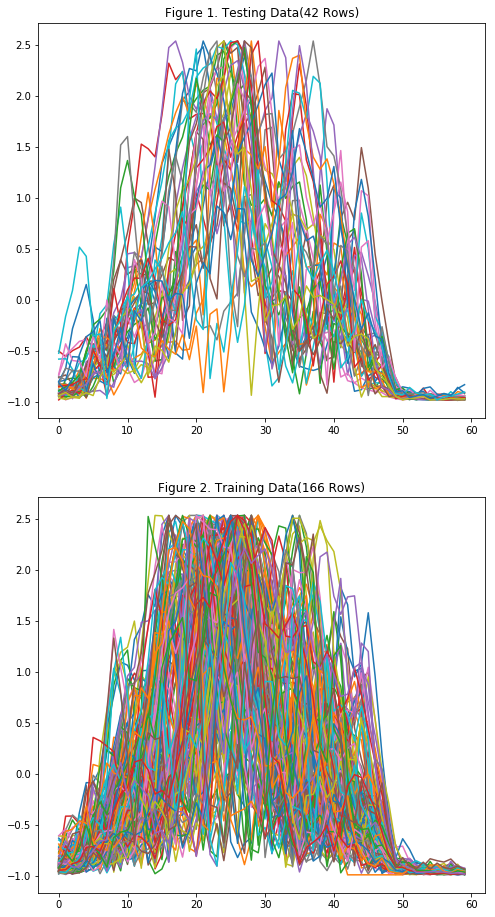

In [4]:
# Plotting
f1 = plt.figure(1, figsize=(8,16))
f1.clf()
test_data_plot  = f1.add_subplot(211)
test_data_plot.set_title("Figure 1. Testing Data(42 Rows)")
train_data_plot = f1.add_subplot(212)
train_data_plot.set_title("Figure 2. Training Data(166 Rows)")

for i in test_data_x:
    test_data_plot.plot(i)
for i in train_data_x:
    train_data_plot.plot(i)

In [5]:
def IRLS(data_x, data_y):
    length        = len(data_x)
    not_converged = True
    w             = np.zeros(61)
    p             = np.empty(length)
    s             = np.empty(length)
    z             = np.empty(length)

#     ones          = np.ones(200)
#     ones[100:]    = ones[100:]*-1
    
#     temp_var      = np.hstack((ones[None].T,data_x))
#     np.random.shuffle(temp_var)
    
    y             = data_y
    data          = data_x
    print('Data shape is', data.shape, "data.T:",data.T.shape)
    
    i_count = 0
    while not_converged:
        
        w_prev = w
        for i in range(length):
            p[i] = np.exp(w_prev.dot(data[i])) / (1 + np.exp(w_prev.dot(data[i])))
            s[i] = p[i]*(1-p[i])          
#             if math.isnan(s[i]): s[i]=1
            z[i] = w_prev.dot(data[i]) + (y[i]-p[i])/(max(s[i],0.00001))
#         print("shape of z:", z.shape)
        diag_s = np.diag(s)
#         print("diag_s:",diag_s.shape)
        t1     = np.linalg.inv(np.dot(np.dot(data.T, diag_s), data))
#         print("t1 shape", t1.shape)
        t2     = np.dot(np.dot(data.T, diag_s), z)
#         print("t1 and t2", t1.shape, t2.shape)
        # Here w should be (61,), t1(61,x), t2(x,1)
        w      = np.dot(t1, t2)
        w      = w/np.linalg.norm(w)
        
        i_count = i_count + 1
        print('Iterations',i_count)
        
        if abs(sum(w-w_prev)) < 0.000001:
            
            print("Converged!!")
            not_converged = False
            return w
            
        elif sum(abs(w)) > 900 or math.isnan(w[0]):
            
            print("Not converging!!!")
            return w
            
    return w

In [6]:
ones = np.ones(len(train_data_x))[None].T
train_data_x_1s = np.hstack((ones, train_data_x))

In [7]:
result = IRLS(train_data_x_1s, train_data_y)

Data shape is (166, 61) data.T: (61, 166)
Iterations 1
Iterations 2
Iterations 3
Iterations 4
Converged!!


In [60]:
def LR_prob(w,x):
#     w = w[None].T
    term1 = np.exp(np.dot(w,x))
    term2 = 1 + np.exp(np.dot(w,x))
    prob  = term1/term2
    
    return prob

def LR_accuracy(x, y, result):
    ones = np.ones(len(x))[None].T
    x = np.hstack((ones, x))
    
    prob = LR_prob(result, x)
    # LR results
    LR_results = prob>0.5
    # Ground Truth
    OG_results = y>0
    # Comparing these 2 results
    acc = sum(~np.logical_xor(s_test,s_train))/len(result)
    
    return acc

In [61]:
LR_accuracy(test_data_x, test_data_y, result)

ValueError: shapes (61,1) and (41,61) not aligned: 1 (dim 1) != 41 (dim 0)

In [64]:
LR_prob(result,train_data_x)

ValueError: shapes (61,1) and (166,60) not aligned: 1 (dim 1) != 166 (dim 0)